In [1]:
import os
from os import path
from urllib.request import urlretrieve
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

Using TensorFlow backend.


## I - Load and preprocess data

In [2]:
(X_tr, y_tr), (X_te, y_te) = fashion_mnist.load_data()
labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

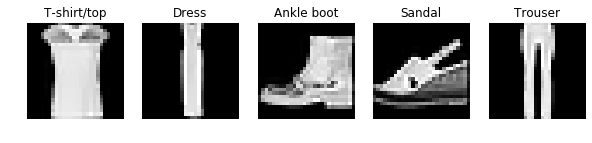

In [3]:
plt.figure(figsize=(10, 2))
for i in range(0, 5):
    index = np.random.randint(0, X_tr.shape[0])
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_tr[index], cmap="gray")
    plt.title(labels[y_tr[index]])
    plt.axis("off")
plt.show()

In [4]:
def min_max_scaling(X):
    minx, maxx = np.min(X, axis=0), np.max(X, axis=0)
    return (X - minx) / (maxx - minx)

In [5]:
X_tr, X_te = min_max_scaling(X_tr), min_max_scaling(X_te)

## II - Simple Autoencoder

We are going to start in this part by defining a simple autoencoder:
- the encoder has two Dense layers projecting into a latent dimension of fixed size (here we are going to choose latent_dim=2 for simplicity)
- the decoder has also two Denser layers and tries to recontruct the original images

<img src="../images/autoencoder.png" width="500px" />

In [6]:
from keras.layers import Input, Dense
from keras import Model

class Autoencoder():
    def __init__(self, X_tr, X_te, y_tr, y_te, labels, latent_dim=2, intermediate_dim=256, flatten=True):
        # Data
        if flatten:
            self.X_tr = self.flatten_image(X_tr)
            self.X_te = self.flatten_image(X_te)
        else:
            self.X_tr = X_tr
            self.X_te = X_te
        self.y_tr = y_tr
        self.y_te = y_te
        self.labels = labels
        # Hyperparameters
        self.original_dim = self.X_tr.shape[1]
        self.intermediate_dim = intermediate_dim
        self.latent_dim = latent_dim
        # Models
        self.encoder = None
        self.decoder = None
        self.model = None
        
    def flatten_image(self, X):
        return X.reshape((X.shape[0], np.prod(X.shape[1:])))
    
    """
    Two Dense layers with relu activation
    They respectively project into intermediate_dim and latent_dim dimensions
    """
    def design_and_compile_encoder(self):
        x = Input(shape=(self.original_dim,))
        hidden = Dense(self.intermediate_dim, activation='relu')(x)
        latent = Dense(self.latent_dim, activation='relu')(hidden)
        return Model(
            inputs=x, 
            outputs=latent, 
            name="mlp_encoder"
        )
    
    """
    Two Dense layers, the first has a relu activation and the last a sigmoid activation
    Sigmoid activation can indeed be used in this case because our images have been min-max scaled previously
    They respectively project into intermediate_dim and latent_dim dimensions
    """
    def design_and_compile_decoder(self):   
        latent = Input(shape=(self.latent_dim,))
        hidden = Dense(self.intermediate_dim, activation='relu')(latent)
        x = Dense(self.original_dim, activation='sigmoid')(hidden)
        return Model(
            inputs=latent, 
            outputs=x,
            name="mlp_decoder"
        )
    
    """
    Define and compile the encoder/decoder models by calling the previous methods
    Store them into self.encoder and self.decoder
    You can now define your final model in self.model
    """
    def design_and_compile_full_model(self):
        self.encoder = self.design_and_compile_encoder()
        self.decoder = self.design_and_compile_decoder()
        
        x = Input(shape=(self.original_dim, ), name="input")
        z = self.encoder(x)
        x_decoded = self.decoder(z)
        self.model = Model(x, x_decoded)

        self.model.compile(optimizer='adam', loss='mse')
        
    def model_summary(self):
        self.model.summary()
        
    def train(self, epochs=5, batch_size=100):
        self.model.fit(
            self.X_tr, self.X_tr,
            epochs=epochs, batch_size=batch_size,
            validation_data=(self.X_te, self.X_te)
        )
        
    def plot_x_test_decoded_i(self, index):
        plt.subplot(1, 2, 1)
        plt.imshow(self.X_te[index].reshape(28, 28), cmap=plt.cm.gray)
        plt.title("Real image")
        z = self.encoder.predict(np.expand_dims(self.X_te[index], axis=0))
        decoded_image = self.decoder.predict(z)
        plt.subplot(1, 2, 2)
        plt.imshow(decoded_image.reshape(28, 28), cmap=plt.cm.gray)
        plt.title("Reconstructed image")
        plt.axis('off');
        
    def plot_latent_space(self):
        Z_te = self.encoder.predict(self.X_te, batch_size=100)
        if isinstance(Z_te, list):
            Z_te = Z_te[0]
        plt.figure(figsize=(7, 6))
        plt.scatter(Z_te[:, 0], Z_te[:, 1], c=self.y_te,
                    cmap=plt.cm.tab10)
        cb = plt.colorbar()
        cb.set_ticks(list(range(len(self.labels))))
        cb.set_ticklabels(self.labels)
        cb.update_ticks()
        plt.show()

In [7]:
ae = Autoencoder(X_tr, X_te, y_tr, y_te, labels)
ae.design_and_compile_full_model()
ae.model_summary()
ae.train(epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
mlp_encoder (Model)          (None, 2)                 201474    
_________________________________________________________________
mlp_decoder (Model)          (None, 784)               202256    
Total params: 403,730
Trainable params: 403,730
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 8s 128us/step - loss: 0.0561 - val_loss: 0.0388
Epoch 2/50
60000/60000 [==============================] - 7s 113us/step - loss: 0.0368 - val_loss: 0.0353
Epoch 3/50
60000/60000 [==============================] - 7s 112us/step - loss: 0.0344 - val_loss: 0.0336
Epoch 4/50
60000/60000 [========

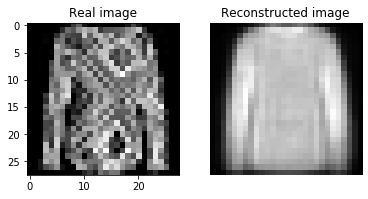

In [8]:
index = np.random.randint(0, ae.X_te.shape[0])

ae.plot_x_test_decoded_i(index)

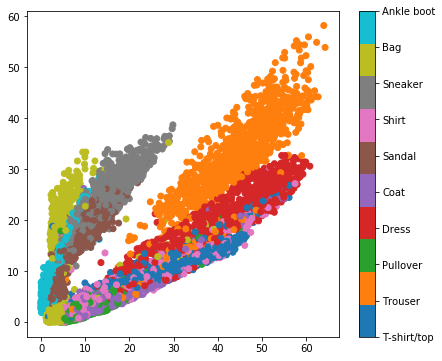

In [9]:
ae.plot_latent_space()

## III - Fully Connected VAE

In this part we are going to improve our simple autoencoder model by adding a gaussian noise in the latent representation

The objective is to estimate both $q_{\phi}(z | x)$ and $p_{\theta}(x | z)$

<img src="../images/vae_horiz.png" width="700px" />

We can use the reparametrization trick to ensure that our samples are deterministically dependent on the parameters of the distribution

Instead of sampling $z$ as below:
$$ z \sim \mathcal{N}(\mu(x), \sigma(x)) $$

We can do the following:
$$ z = \mu(x) + \sigma(x) \cdot \epsilon$$
with:
$$ \epsilon \sim \mathcal{N}(0, 1) $$

In practice the encoder actually parametrizes $log(\sigma^2(x)$ and not solely $\sigma(x)$<br/>
We take the exponential of $log(\sigma^2_z(x)$ afterwards in the sampler layer, which ensures the positivity of the final $\sigma$ that we are trying to learn

In [10]:
from keras.layers import Lambda
from keras import backend as K
from keras import metrics

class VariationalAutoencoder(Autoencoder):
    def __init__(self, X_tr, X_te, y_tr, y_te, labels, latent_dim=2, intermediate_dim=256, flatten=True):
        # Autoencoder class initialization
        super(VariationalAutoencoder, self).__init__(
            X_tr, X_te, y_tr, y_te, labels, latent_dim, intermediate_dim, flatten
        )
        # Models
        self.sampler = None
    
    """
    The first Dense layer is identical to the standard autoencoder
    However, it is now mandatory to have two parallel Dense layers projecting into self.latent_dim
    They are respectively estimating z_mean and z_log_var
    """
    def design_and_compile_encoder(self):
        x = Input(shape=(self.original_dim,))
        hidden = Dense(self.intermediate_dim, activation='relu')(x)
        z_mean = Dense(self.latent_dim)(hidden)
        z_log_var = Dense(self.latent_dim)(hidden)
        return Model(
            inputs=x, 
            outputs=[z_mean, z_log_var], 
            name="mlp_encoder"
        )
    
    """
    Now we can use the estimated z_mean and z_log_var to sample z using a gaussian distribution
    Define your inputs, wrap the sampling function in a Lambda layer, 
    and return a Model Keras Object that outputs the stochastic latent variable z
    """
    def design_and_compile_sampler(self):
        def _sampling(inputs):
            z_mean, z_log_var = inputs
            batch_size = K.shape(z_mean)[0]
            epsilon = K.random_normal(shape=(batch_size, self.latent_dim),
                                      mean=0., stddev=1.)
            return z_mean + K.exp(z_log_var / 2) * epsilon
    
        z_mean = Input(shape=(self.latent_dim,))
        z_log_var = Input(shape=(self.latent_dim,))
        z = Lambda(_sampling, output_shape=(self.latent_dim,))([z_mean, z_log_var])
        return Model(
            inputs=[z_mean, z_log_var], 
            outputs=z,
            name="mlp_sampler"
        )
    
    """
    The decoder is actually the same as the previous part in the standard autoencoder model
    """
    def design_and_compile_decoder(self):
        latent = Input(shape=(self.latent_dim,))
        hidden = Dense(self.intermediate_dim, activation='relu')(latent)
        x = Dense(self.original_dim, activation='sigmoid')(hidden)
        return Model(
            inputs=latent, 
            outputs=x, 
            name="mlp_decoder"
        )
    
    """
    Now you can use the three models that you have defined and compiled, 
    store them into self.encoder, self.sampler and self.decoder
    Your final model will be defined in self.model afterward
    The used loss function is the negative ELBO
    """
    def design_and_compile_full_model(self):
        self.encoder = self.design_and_compile_encoder()
        self.sampler = self.design_and_compile_sampler()
        self.decoder = self.design_and_compile_decoder()
        
        x = Input(shape=self.X_tr.shape[1:], name="input")
        z_mean, z_log_var = self.encoder(x)
        z = self.sampler([z_mean, z_log_var])
        x_decoded_mean = self.decoder(z)
        self.model = Model(x, x_decoded_mean)

        xent_loss = self.original_dim * metrics.binary_crossentropy(
            K.flatten(x), K.flatten(x_decoded_mean)
        )
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        vae_loss = K.mean(xent_loss + kl_loss)

        self.model.add_loss(vae_loss)
        self.model.compile(optimizer='adam')
        
    def train(self, epochs=5, batch_size=100):
        self.model.fit(
            self.X_tr, 
            epochs=epochs, batch_size=batch_size,
            validation_data=(self.X_te, None)
        )
        
    def plot_x_test_decoded_i(self, index):
        plt.subplot(1, 2, 1)
        plt.imshow(self.X_te[index].reshape(28, 28), cmap=plt.cm.gray)
        plt.title("Real image")
        z_mean, z_log_var = self.encoder.predict(np.expand_dims(self.X_te[index], axis=0))
        z = self.sampler.predict([z_mean, z_log_var])
        decoded_image = self.decoder.predict(z)
        plt.subplot(1, 2, 2)
        plt.imshow(decoded_image.reshape(28, 28), cmap=plt.cm.gray)
        plt.title("Reconstructed image")
        plt.axis('off');
        
    def plot_sampled_prediction(self):
        random_z_from_prior = np.random.normal(size=(1, self.latent_dim))
        generated = self.decoder.predict(random_z_from_prior)
        plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
        plt.axis('off');

In [11]:
vae = VariationalAutoencoder(X_tr, X_te, y_tr, y_te, labels)
vae.design_and_compile_full_model()
vae.model_summary()
vae.train(epochs=50)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 784)          0                                            
__________________________________________________________________________________________________
mlp_encoder (Model)             [(None, 2), (None, 2 201988      input[0][0]                      
__________________________________________________________________________________________________
mlp_sampler (Model)             (None, 2)            0           mlp_encoder[1][0]                
                                                                 mlp_encoder[1][1]                
__________________________________________________________________________________________________
mlp_decoder (Model)             (None, 784)          202256      mlp_sampler[1][0]                
Total para

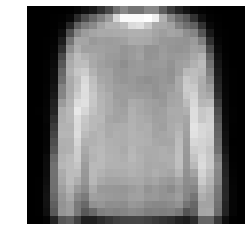

In [12]:
vae.plot_sampled_prediction()

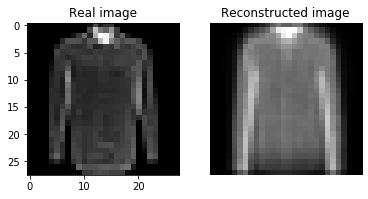

In [13]:
index = np.random.randint(0, vae.X_te.shape[0])

vae.plot_x_test_decoded_i(index)

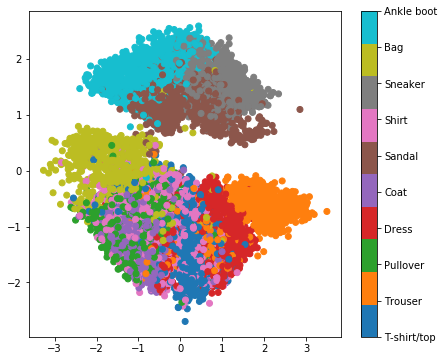

In [14]:
vae.plot_latent_space()

## IV - Convolutional VAE

In this final part, we are going to enrich the previous encoder and decoder with convolutional layers

This allows us not to destroy the precious spatial representation in our images and extract local patterns that can be encoded

In [15]:
from keras.layers import Flatten, Conv2D, BatchNormalization, Reshape, Conv2DTranspose

class ConvolutionalVariationalAutoencoder(VariationalAutoencoder):
    def __init__(self, X_tr, X_te, y_tr, y_te, labels, 
                 latent_dim=2, intermediate_dim=128, 
                 filters=32, kernel_size=3, spatial_size=7,
                 flatten=False):
        X_tr = np.expand_dims(X_tr, axis=-1)
        X_te = np.expand_dims(X_te, axis=-1)
        # VAE class initialization
        super(ConvolutionalVariationalAutoencoder, self).__init__(
            X_tr, X_te, y_tr, y_te, labels, latent_dim, intermediate_dim, flatten
        )
        # Hyperparameters
        self.filters = filters
        self.kernel_size = kernel_size
        self.spatial_size = spatial_size
        # Models
        self.sampler = None
    
    """
    Use series of Conv2D layers with strides and batch normalization, and then continue with a Flatten layer
    Add Dense layers afterwards to estimate z_mean and z_log_var
    """
    def design_and_compile_encoder(self):
        x = Input(shape=self.X_tr.shape[1:])
        x_conv = Conv2D(self.filters,
                        kernel_size=self.kernel_size,
                        padding='same', activation='relu')(x)
        x_conv = BatchNormalization()(x_conv)
        x_conv = Conv2D(self.filters,
                        kernel_size=self.kernel_size,
                        padding='same', activation='relu',
                        strides=(2, 2))(x_conv)
        x_conv = BatchNormalization()(x_conv)
        x_conv = Conv2D(self.filters,
                        kernel_size=self.kernel_size,
                        padding='same', activation='relu')(x_conv)
        x_conv = BatchNormalization()(x_conv)
        x_conv = Conv2D(self.filters,
                        kernel_size=self.kernel_size,
                        padding='same', activation='relu',
                        strides=(2, 2))(x_conv)
        x_flat = Flatten()(x_conv)
        hidden = Dense(self.intermediate_dim, activation='relu')(x_flat)
        z_mean = Dense(self.latent_dim)(hidden)
        z_log_var = Dense(self.latent_dim)(hidden)
        return Model(
            inputs=x, 
            outputs=[z_mean, z_log_var], 
            name="convolutional_encoder"
        )
    
    """
    Here we need a transformation going in the opposite direction of a normal Conv2D layer: Conv2DTranspose
    It starts from the latent space to upsample to the image original dimension
    Start with two Dense layers into a hidden dimension of (self.filters * self.spatial_size * self.spatial_size),
    then use a Reshape layer to convert it to a 3D tensor: it will be your starting point for deconvolution layers
    You can now use series of Conv2DTranspose layers with strides and batch normalization
    Conclude your model with a standard Conv2D layer with sigmoid activation, and make sure you ends up with 
    the same dimensions as your original image
    """
    def design_and_compile_decoder(self):
        decoder_input = Input(shape=(self.latent_dim,))
        x = Dense(self.intermediate_dim, activation='relu')(decoder_input)
        x = Dense(self.filters * self.spatial_size * self.spatial_size, activation='relu')(x)
        x = Reshape((self.spatial_size, self.spatial_size, self.filters))(x)

        x = Conv2DTranspose(self.filters,
                            kernel_size=self.kernel_size,
                            padding='same',
                            strides=(2, 2),
                            activation='relu')(x)
        x = BatchNormalization()(x)
        x = Conv2DTranspose(self.filters,
                            kernel_size=self.kernel_size,
                            padding='same',
                            strides=1,
                            activation='relu')(x)
        x = BatchNormalization()(x)

        x = Conv2DTranspose(self.filters,
                            kernel_size=self.kernel_size,
                            padding='valid',
                            strides=(2, 2),
                            activation='relu')(x)
        x = BatchNormalization()(x)
        x = Conv2D(1, kernel_size=2, padding='valid',
               activation='sigmoid')(x)
        return Model(decoder_input, x, name='convolutional_decoder')

In [16]:
pretrained = True

cvae = ConvolutionalVariationalAutoencoder(X_tr, X_te, y_tr, y_te, labels)
cvae.design_and_compile_full_model()
if pretrained:
    url = 'https://github.com/ECE-Deep-Learning/courses_labs/releases/download/0.3/cvae_weights.h5'
    pretrained_weights_file = os.path.join('.', 'cvae_weights.h5')
    if not path.exists(pretrained_weights_file):
        print('Downloading from %s to %s...' % (
            url,
            pretrained_weights_file
        ))
        urlretrieve(url, pretrained_weights_file)
        print('Downloaded pre-trained weights')
    cvae.model.load_weights("cvae_weights.h5")
else:
    cvae.model_summary()
    cvae.train(epochs=50)

Downloaded pre-trained weights


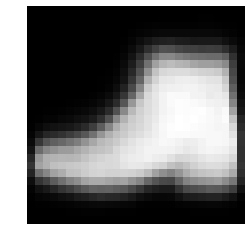

In [17]:
cvae.plot_sampled_prediction()

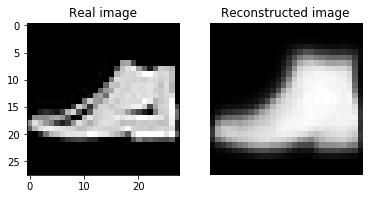

In [30]:
index = np.random.randint(0, cvae.X_te.shape[0])

cvae.plot_x_test_decoded_i(index)

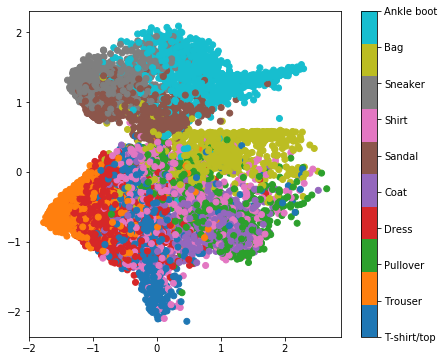

In [31]:
cvae.plot_latent_space()